Ce script, conçu pour être exécuté par exemple dans un environnement Jupyter ou en tant que script autonome, réalise la partie « réception » d’un système de transmission de données. Il prend en entrée des fichiers CSV générés lors de l’émission (contenant des signaux modulés en ASK et FSK), puis effectue plusieurs étapes de traitement pour récupérer le message initial. Voici une description détaillée de chaque partie du code :

---

### 1. **Imports et Configuration Initiale**

- **Bibliothèques utilisées :**
  - `numpy` pour la gestion des tableaux et des opérations numériques.
  - `matplotlib.pyplot` pour tracer des graphiques.
- **Style graphique :**
  - Le style `ggplot` est appliqué pour obtenir une esthétique similaire à la partie émission.

---

### 2. **Fonction `retourASKetFSK()`**

Cette fonction lit les fichiers CSV **"Message_ASK.csv"** et **"Message_FSK.csv"** qui contiennent les signaux modulés générés lors de l’émission. Elle réalise ensuite la démodulation pour extraire les séquences de bits.

#### **Étapes principales :**

1. **Paramétrage commun :**  
   - `Fe = 44100 Hz` : fréquence d’échantillonnage.
   - `baud = 200 bits/s` : débit binaire.
   - `Ns` : nombre d’échantillons par bit (calculé par `Fe/baud`).
   - Définition de la porteuse ASK à 2000 Hz (`Fp`) et des deux porteuses FSK à 200 Hz (`fp1`) et 3000 Hz (`fp2`).

2. **Chargement des signaux :**  
   - Les signaux modulés ASK et FSK sont lus depuis leurs fichiers CSV.

3. **Démodulation ASK :**
   - **Génération de la porteuse :** Une sinusoïde à 2000 Hz est générée sur l’intervalle de temps correspondant.
   - **Produit avec le signal reçu :** Le signal ASK reçu est multiplié par la porteuse, ce qui permet d’amplifier ou d’atténuer les composantes en phase avec la porteuse.
   - **Intégration par blocs :**  
     Le signal résultant est découpé en blocs de `Ns` échantillons (correspondant à un bit). Pour chaque bloc, une intégration numérique (avec `np.trapz`) est réalisée.
   - **Décision binaire :**  
     Pour chaque intégrale, si la valeur est positive, le bit est considéré comme `1`, sinon comme `0`.

4. **Démodulation FSK (pour information) :**
   - Deux porteuses (200 Hz et 3000 Hz) sont générées.
   - Le signal FSK reçu est multiplié par chacune des porteuses.
   - Pour chaque bloc de `Ns` échantillons, l’intégrale est calculée pour chaque multiplication. La comparaison de ces intégrales permet de décider si le bit vaut `1` (si l’intégrale avec `fp1` est supérieure) ou `0` (sinon).
   
5. **Affichage Graphique :**
   - Plusieurs graphiques sont générés pour visualiser :
     - Le signal ASK reçu.
     - La porteuse utilisée pour l’ASK.
     - Le produit du signal ASK et de la porteuse.
     - Le signal FSK reçu.
     
6. **Retour de la fonction :**  
   La fonction affiche des extraits des signaux démodulés et retourne la séquence de bits démodulés côté ASK (liste d’entiers `0/1`).

---

### 3. **Fonction `Manchester_decode(bits)`**

Cette fonction réalise le décodage du signal codé en Manchester.  
**Principe du décodage :**
- Le codage Manchester transforme chaque bit en deux valeurs :
  - Le couple `(1, 0)` représente le bit `1`.
  - Le couple `(0, 1)` représente le bit `0`.
- La fonction lit la séquence par paires et, selon le motif rencontré, reconstitue la séquence binaire originale.
- Le résultat est affiché et renvoyé.

---

### 4. **Fonction `trame_reception(bits)`**

Cette fonction extrait la trame de données reçue en identifiant et en retirant les fanions de début et de fin, ainsi que l’octet de protocole.

#### **Étapes principales :**

- **Vérification des fanions :**
  - Le fanion de début attendu est `[1,1,1,1,1,1,1,1]` et celui de fin est `[0,0,0,0,0,0,0,0]`.
  - Si les fanions ne sont pas conformes, la trame est considérée comme invalide.
  
- **Extraction du protocole et des données :**
  - Après retrait des fanions, les 8 premiers bits sont interprétés comme l’octet de protocole.
  - Dans ce cas, l’octet de protocole attendu pour un fichier texte est `[1,1,0,0,0,0,1,1]`.
  - Le reste des bits constitue la donnée utile.

---

### 5. **Fonction `crcreception(bits)`**

Cette fonction vérifie l’intégrité des données à l’aide d’un code CRC.  
**Principe de vérification :**
- Les données sont organisées en blocs de 12 bits, comprenant 8 bits de données suivis de 4 bits de reste.
- Pour chaque bloc, le reste est recalculé en ajoutant quatre zéros aux données (similaire à l’émission) et en réalisant une division par le diviseur binaire `"1001"` (équivalent à 9 en décimal).
- Si le reste calculé correspond au reste reçu, l’intégrité est validée pour ce bloc.
- La fonction retourne la séquence de données (sans les bits de CRC) si toutes les vérifications sont correctes, sinon elle signale une erreur.

---

### 6. **Fonction `ASCII_decode(bits, type_fichier)`**

Cette fonction convertit une séquence binaire en texte :
- La chaîne de bits est découpée par groupes de 8 bits, chaque groupe correspondant à un caractère en ASCII.
- Le message décodé est affiché en fonction du type de fichier (ici, pour un fichier texte).

---

### 7. **Fonction `reception_main()`**

Cette fonction orchestre l’ensemble du processus de réception et de décodage :
1. **Démodulation :**  
   Appel à `retourASKetFSK()` pour récupérer la séquence de bits issue du signal ASK.
2. **Décodage Manchester :**  
   Transformation de la séquence en bits originaux grâce à `Manchester_decode()`.
3. **Extraction de la trame :**  
   La fonction `trame_reception()` est utilisée pour vérifier et extraire le protocole ainsi que les données utiles.
4. **Vérification CRC :**  
   Les données sont vérifiées par la fonction `crcreception()` pour s’assurer de leur intégrité.
5. **Décodage ASCII :**  
   Enfin, `ASCII_decode()` convertit les données binaires en message texte.

---

### 8. **Programme Principal**

Le bloc conditionnel  
```python
if __name__ == "__main__":
```
permet de lancer la fonction `reception_main()` lorsque le script est exécuté directement. Ce bloc affiche un titre informatif puis enchaîne toutes les étapes de la réception et du décodage du message.

---

### **Résumé Global**

Ce script fait partie d’un système de transmission/démodulation de données et se décompose en plusieurs étapes :

- **Lecture des signaux modulés** depuis des fichiers CSV.
- **Démodulation** du signal ASK (et, à titre informatif, du signal FSK) par multiplication par la porteuse, intégration par blocs et prise de décision.
- **Décodage Manchester** pour revenir à la séquence binaire initiale.
- **Extraction de la trame** en retirant les fanions de début/fin et en identifiant le protocole.
- **Vérification CRC** pour s’assurer de l’intégrité des données reçues.
- **Décodage ASCII** afin de reconstituer le message texte d’origine.

L’ensemble de ces étapes permet, une fois le signal reçu et traité, d’afficher le message transmis à partir des données modulées.


--------------------------------------------
   RÉCEPTION : Lecture & Décodage du Signal
--------------------------------------------
    
Signal modulé ASK (extrait) : [0.       0.281111 0.539551 0.754476 0.908553 0.989355 0.990367 0.911506
 0.759132 0.545535] ...
Signal modulé FSK (extrait) : [0.       0.028491 0.056959 0.085381 0.113734 0.141994 0.170139 0.198146
 0.225992 0.253655] ...


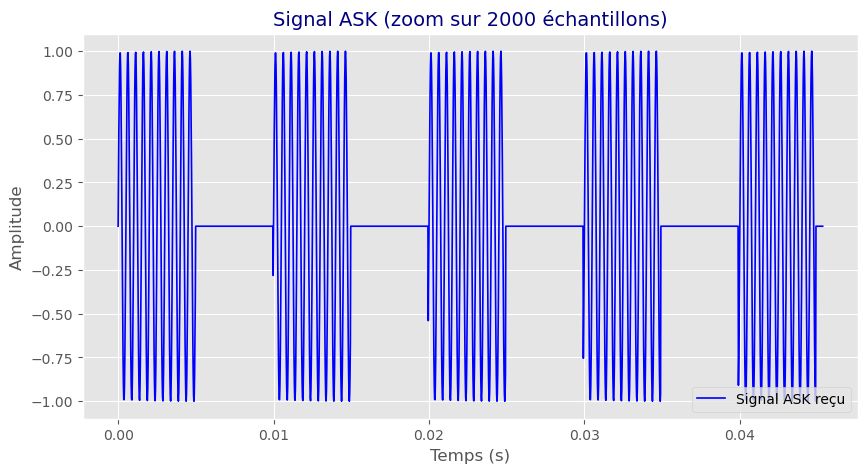

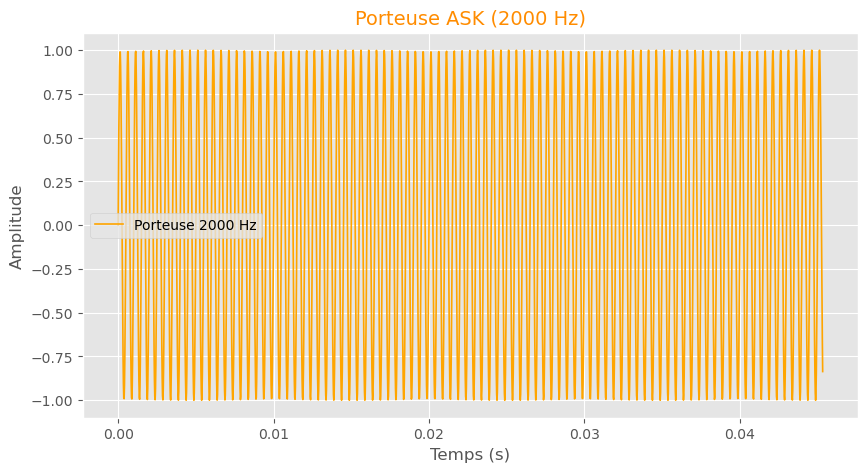

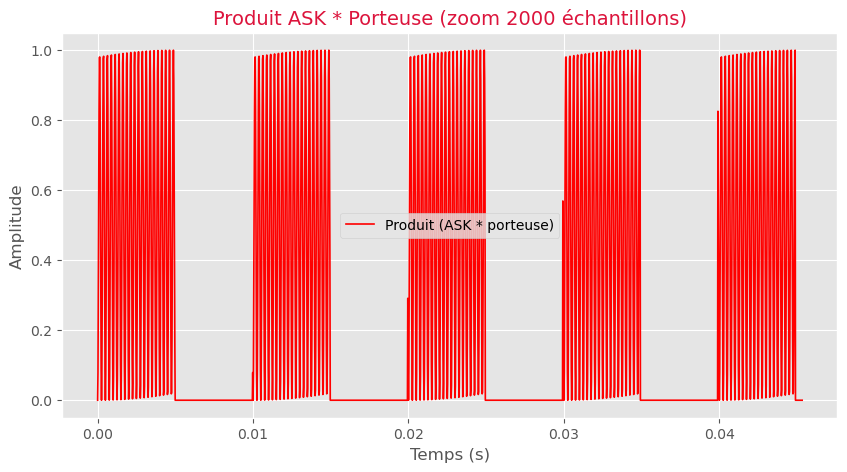

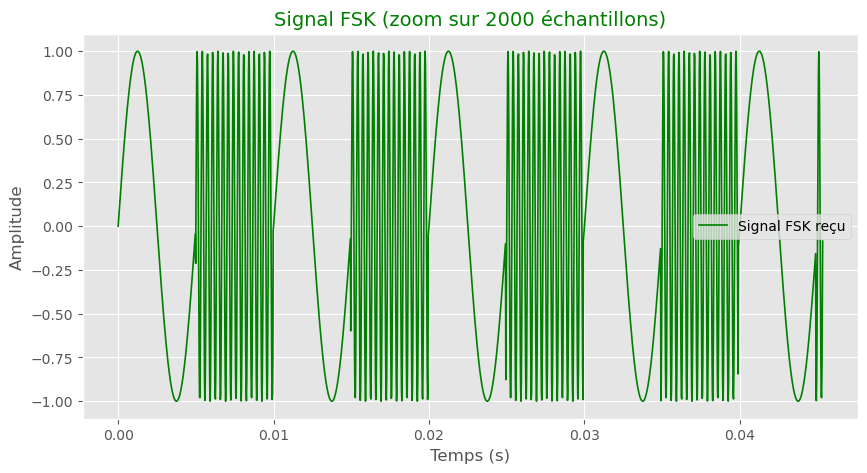

Signal démodulé ASK (bits) : [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1] ...
Signal démodulé FSK (bits) : [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1] ...
Décodage Manchester : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Fanion début : [1, 1, 1, 1, 1, 1, 1, 1]
Fanion fin   : [0, 0, 0, 0, 0, 0, 0, 0]
Protocole : [1, 1, 0, 0, 0, 0, 1, 1]
Type de fichier : txt
CRC OK, aucune erreur détectée.
Données après retrait CRC : [0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0]
Message reçu : niel


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Pour un style de graphe similaire à la première partie
plt.style.use('ggplot')

def retourASKetFSK():
    """
    Lit 'Message_ASK.csv' et 'Message_FSK.csv' (générés par la partie émission).
    1) Démodule ASK : multiplication par la porteuse puis intégration par paquets de Ns.
    2) Démodule FSK (pour info) : multiplication par deux porteuses, puis comparaison.
    3) Affiche des graphiques (ASK reçu, produit avec porteuse, FSK, etc.).
    
    Retourne la séquence de bits démodulés côté ASK (liste d'entiers 0/1).
    """
    # -- Paramètres (doivent correspondre à la partie émission) --
    Fe   = 44100            # Fréquence d'échantillonnage
    baud = 200              # Débit binaire (bit/s)
    Ns   = int(Fe / baud)   # Nombre d'échantillons par bit (théoriquement ~220)
    Fp   = 2000             # Porteuse ASK
    fp1  = 200              # Porteuse FSK pour bit=1
    fp2  = 3000             # Porteuse FSK pour bit=0

    # -- Chargement des signaux CSV --
    # Assurez-vous que "Message_ASK.csv" et "Message_FSK.csv" 
    # sont dans le même dossier que ce script.
    ASK1 = np.genfromtxt("Message_ASK.csv", delimiter=',')
    FSK1 = np.genfromtxt("Message_FSK.csv", delimiter=',')
    
    print("Signal modulé ASK (extrait) :", ASK1[:10], "...")
    print("Signal modulé FSK (extrait) :", FSK1[:10], "...")

    N = len(ASK1)  # Nombre total d'échantillons
    t = np.arange(N) / Fe

    # ------------------------------------------------
    #            Démodulation ASK
    # ------------------------------------------------
    porteuse_ASK = np.sin(2 * np.pi * Fp * t)
    produit_ASK  = ASK1 * porteuse_ASK

    # Intégration par blocs de Ns pour déterminer s'il s'agit de 0 ou 1
    y = []
    for i in range(0, N, Ns):
        portion = produit_ASK[i : i + Ns]
        # Intégration (trapz) approximative sur la portion
        y.append(np.trapz(portion))

    # Décision : si > 0 => bit 1, sinon bit 0
    bits_ASK = [1 if val > 0 else 0 for val in y]

    # -- Affichages graphiques pour la partie ASK --
    # 1) Signal ASK reçu
    plt.figure(figsize=(10,5))
    plt.plot(t[:2000], ASK1[:2000], color='blue', linewidth=1.2, label='Signal ASK reçu')
    plt.title("Signal ASK (zoom sur 2000 échantillons)", fontsize=14, color='navy')
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

    # 2) Porteuse ASK
    plt.figure(figsize=(10,5))
    plt.plot(t[:2000], porteuse_ASK[:2000], color='orange', linewidth=1.2, label='Porteuse 2000 Hz')
    plt.title("Porteuse ASK (2000 Hz)", fontsize=14, color='darkorange')
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

    # 3) Produit du signal ASK et de la porteuse
    plt.figure(figsize=(10,5))
    plt.plot(t[:2000], produit_ASK[:2000], color='red', linewidth=1.2, label='Produit (ASK * porteuse)')
    plt.title("Produit ASK * Porteuse (zoom 2000 échantillons)", fontsize=14, color='crimson')
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

    # ------------------------------------------------
    #            Démodulation FSK (pour info)
    # ------------------------------------------------
    s1 = np.sin(2 * np.pi * fp1 * t)
    s2 = np.sin(2 * np.pi * fp2 * t)

    prod1 = FSK1 * s1
    prod2 = FSK1 * s2

    Res1, Res2 = [], []
    for i in range(0, N, Ns):
        Res1.append(np.trapz(prod1[i : i + Ns]))
        Res2.append(np.trapz(prod2[i : i + Ns]))

    # Décision : si intégrale s1 > s2 => bit 1, sinon 0
    bits_FSK = [1 if Res1[k] > Res2[k] else 0 for k in range(len(Res1))]

    # -- Affichage graphique FSK --
    plt.figure(figsize=(10,5))
    plt.plot(t[:2000], FSK1[:2000], color='green', linewidth=1.2, label='Signal FSK reçu')
    plt.title("Signal FSK (zoom sur 2000 échantillons)", fontsize=14, color='green')
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

    plt.show()

    print("Signal démodulé ASK (bits) :", bits_ASK[:50], "...")
    print("Signal démodulé FSK (bits) :", bits_FSK[:50], "...")

    # On retourne uniquement la séquence ASK pour la suite
    return bits_ASK

def Manchester_decode(bits):
    """
    Décodage Manchester :
      - (1,0) => bit 1
      - (0,1) => bit 0
    On lit la liste 2 par 2.
    """
    decode = []
    for i in range(0, len(bits)//2):
        b1 = bits[2*i]
        b2 = bits[2*i + 1]
        if b1 == 1 and b2 == 0:
            decode.append(1)
        elif b1 == 0 and b2 == 1:
            decode.append(0)
        else:
            # Pattern inhabituel, possible erreur
            pass
    print("Décodage Manchester :", decode)
    return decode

def trame_reception(bits):
    """
    Récupère fanions, protocole, puis renvoie (data_bits, type_fichier).
    Fanion début : 11111111
    Fanion fin   : 00000000
    Octet protocole (txt) : 11000011 (dans votre code, c'est 11000011 ou 11000011, à vérifier)
    Ici, c'est [1,1,0,0,0,0,1,1].
    """
    if len(bits) < 16:
        print("Trame trop courte, pas de fanions.")
        return None, None

    fanion_debut = bits[:8]
    fanion_fin   = bits[-8:]
    print("Fanion début :", fanion_debut)
    print("Fanion fin   :", fanion_fin)

    if fanion_debut != [1,1,1,1,1,1,1,1] or fanion_fin != [0,0,0,0,0,0,0,0]:
        print("Fanions incorrects. Trame invalide.")
        return None, None

    # On enlève les fanions
    core = bits[8:-8]
    if len(core) < 8:
        print("Pas assez de place pour protocole.")
        return None, None

    protocole = core[:8]
    data_bits = core[8:]
    print("Protocole :", protocole)

    if protocole == [1,1,0,0,0,0,1,1]:
        print("Type de fichier : txt")
        type_fichier = "txt"
    else:
        print("Protocole inconnu.")
        return None, None

    return data_bits, type_fichier

def crcreception(bits):
    """
    Vérifie l'intégrité CRC, en lisant par blocs de 12 bits : 8 data + 4 reste.
    Diviseur = 1001 (9 décimal).
    Retourne les bits de data si OK, ou None si erreur.
    """
    diviseur_dec = int("1001", 2)
    resultat = []
    integrite_ok = True

    idx = 0
    while idx + 12 <= len(bits):
        bloc = bits[idx:idx+12]
        idx += 12

        data_8  = bloc[:8]
        reste_4 = bloc[8:]

        data_str = "".join(str(b) for b in data_8)
        data_plus_0000 = data_str + "0000"
        data_dec = int(data_plus_0000, 2)

        reste_calc_dec = data_dec % diviseur_dec
        reste_calc_str = format(reste_calc_dec, '04b')

        reste_str = "".join(str(b) for b in reste_4)
        if reste_str != reste_calc_str:
            integrite_ok = False

        resultat.extend(data_8)

    if integrite_ok:
        print("CRC OK, aucune erreur détectée.")
        print("Données après retrait CRC :", resultat)
        return resultat
    else:
        print("CRC incorrect : erreur de transmission.")
        return None

def ASCII_decode(bits, type_fichier):
    """
    Convertit la liste binaire (8 bits = 1 caractère ASCII) en message texte.
    """
    if not bits:
        print("Aucune donnée à décoder.")
        return

    bin_str = "".join(str(b) for b in bits)
    message = ""
    for i in range(0, len(bin_str), 8):
        octet = bin_str[i:i+8]
        if len(octet) < 8:
            break
        val = int(octet, 2)
        message += chr(val)

    if type_fichier == "txt":
        print("Message reçu :", message)
    else:
        print("Données ASCII brutes :", message)

def reception_main():
    """
    Enchaîne toutes les étapes :
      1) Démodulation ASK/FSK + affichage
      2) Décodage Manchester
      3) Extraction trame (fanions, protocole)
      4) Vérif CRC
      5) Décodage ASCII
    """
    bits_recu = retourASKetFSK()

    bits_decode = Manchester_decode(bits_recu)

    donnees, type_fic = trame_reception(bits_decode)
    if donnees is None or type_fic is None:
        print("Trame invalide. Stop.")
        return

    data_no_crc = crcreception(donnees)
    if data_no_crc is None:
        print("Erreur CRC. Stop.")
        return

    ASCII_decode(data_no_crc, type_fic)


# -------------------------------------------------------------------------
#                Programme Principal (réception)
# -------------------------------------------------------------------------
if __name__ == "__main__":
    print("""
--------------------------------------------
   RÉCEPTION : Lecture & Décodage du Signal
--------------------------------------------
    """)
    reception_main()
